<a href="https://colab.research.google.com/github/mohanqwerty5/Butterfly-Classifier/blob/master/Butterfly_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Butterfly Classification using Transfer Learning
A multi-class classification approach to categorize the type of Butterfly using Transfer Learning from CNN 'inception_V3' model  in Tensorflow.

## 1. Aim
To create a classifiacation model predicting the breed of the butterfly belonging to the following classes: 

1.   Black_Swallotail (B)
2.   California_Sister (C)
3.   Milberts_Tortoisedhell(M)
4.   Red_Admiral (R)
5.   Red_Spotted_Purple (S)
6.   The_Blues (T)

Since, I am going to use a   pretrained model using transfer learning, hence would like to take less distinguishable images for some classes to see how good the model performs .

 

### First i'll implement the classification using a simple model from scratch and then transfer learning to see the difference.

## 2. Setup

In [0]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 3.1 Loading Dataset

In [26]:
#collecting the path for base directory
base_dir='/content/drive/My Drive/Butterfly-Classifier/datset'
training_dir=os.path.join(base_dir, 'training')
validation_dir=os.path.join(base_dir, 'validation')

train_b_dir=os.path.join(training_dir,'Black_Swallotail')
train_c_dir=os.path.join(training_dir,'California_Sister')
train_m_dir=os.path.join(training_dir,'Milberts_Tortoiseshell')
train_r_dir=os.path.join(training_dir,'Red_Admiral')
train_s_dir=os.path.join(training_dir,'Red_Spotted_Purple')
train_t_dir=os.path.join(training_dir,'The_Blues')



valid_b_dir=os.path.join(validation_dir,'Black_Swallotail')
valid_c_dir=os.path.join(validation_dir,'California_Sister')
valid_m_dir=os.path.join(validation_dir,'Milberts_Tortoiseshell')
valid_r_dir=os.path.join(validation_dir,'Red_Admiral')
valid_s_dir=os.path.join(validation_dir,'Red_Spotted_Purple')
valid_t_dir=os.path.join(validation_dir,'The_Blues')

#Let's find out the total number of horse and human images in the directories:
print('total Black_Swallotail in training: ', len(os.listdir(train_b_dir)))
print('total California_Sister in training: ', len(os.listdir(train_c_dir)))
print('total Milberts_Tortoiseshell in training: ', len(os.listdir(train_m_dir)))
print('total Red_Admiral in training: ', len(os.listdir(train_r_dir)))
print('total Red_Spotted_Purple in training: ', len(os.listdir(train_s_dir)))
print('total The_Blues in training: ', len(os.listdir(train_t_dir)))

print('total Black_Swallotail in validation: ', len(os.listdir(valid_b_dir)))
print('total California_Sister in validation: ', len(os.listdir(valid_c_dir)))
print('total Milberts_Tortoiseshell in validation: ', len(os.listdir(valid_m_dir)))
print('total Red_Admiral in validation: ', len(os.listdir(valid_r_dir)))
print('total Red_Spotted_Purple in validation: ', len(os.listdir(valid_s_dir)))
print('total The_Blues in validation: ', len(os.listdir(valid_t_dir)))



total Black_Swallotail in training:  264
total California_Sister in training:  299
total Milberts_Tortoiseshell in training:  318
total Red_Admiral in training:  304
total Red_Spotted_Purple in training:  307
total The_Blues in training:  302
total Black_Swallotail in validation:  110
total California_Sister in validation:  140
total Milberts_Tortoiseshell in validation:  140
total Red_Admiral in validation:  140
total Red_Spotted_Purple in validation:  104
total The_Blues in validation:  140


## 3.2 Looking at the Dataset

In [9]:
#let's see the file-names in the directories
train_b_names = os.listdir(train_b_dir)
print(train_b_names[:10])
train_c_names = os.listdir(train_c_dir)
print(train_c_names[:10])
train_m_names = os.listdir(train_m_dir)
print(train_m_names[:10])
train_r_names = os.listdir(train_r_dir)
print(train_r_names[:10])
train_s_names = os.listdir(train_s_dir)
print(train_s_names[:10])
train_t_names = os.listdir(train_t_dir)
print(train_t_names[:10])


validation_b_names = os.listdir(valid_b_dir)
print(validation_b_names[:10])
validation_m_names = os.listdir(valid_m_dir)
print(validation_m_names[:10])
validation_c_names = os.listdir(valid_c_dir)
print(validation_c_names[:10])
validation_r_names = os.listdir(valid_r_dir)
print(validation_r_names[:10])
validation_s_names = os.listdir(valid_s_dir)
print(validation_s_names[:10])
validation_t_names = os.listdir(valid_t_dir)
print(validation_t_names[:10])


['l357216184.jpg', 'images50.jpg', 'images45.jpg', 'images46.jpg', 'images44.jpg', 'polyxenesmale.jpg', 'images57.jpg', 'images51.jpg', 'images55.jpg', 'images53.jpg']
['images356.jpg', 'IMG_6721JPG.jpg', 'sister_california-1-b.jpg', 'toz21802l.jpg', 'tumblr_ovk5bgzaZw1wso8p1o1_1280.jpg', 'Smooth-banded-Sister-Butter_6245_3.jpg', 'images72.jpg', 'images58.jpg', 'images63.jpg', 'images62.jpg']
['images350.jpg', 'images138.jpg', 'images123.jpg', 'images139.jpg', 'images132.jpg', 'images148.jpg', 'images146.jpg', 'VZ5L9Z4LGZ9H1H7HBH7HCHMHDHGHPZ0L4ZLLOHKL4ZZL2ZQLPZQLVZXLHRGHPZ4H6ZRL8ZSLTHQLDH5HEZRL5ZQL5ZZL.jpg', 'images144.jpg', 'ZL8ZSLGZ4LBHNHZR8HVHGHOH8H5ZLLGZZL2Z8H5ZILZR7LAZWHHR4H8ZSLBZ2HWZ6HRRPHHR2HJH7LRRGLVZ7LVZ.jpg']
['red-admiral-vanessa-atalanta-pyrameis-atalanta-sits-on-a-white-rose-flower-netherlands-2B1EBJW.jpg', 'red-admiral-vanessa-atalanta-wingspan-60mm-an-active-fast-flying-butterfly-that-is-also-fond-of-basking-in-the-sun-adult-has-marbled-dark-grey-unde-2AK57YC.jpg', 'imag

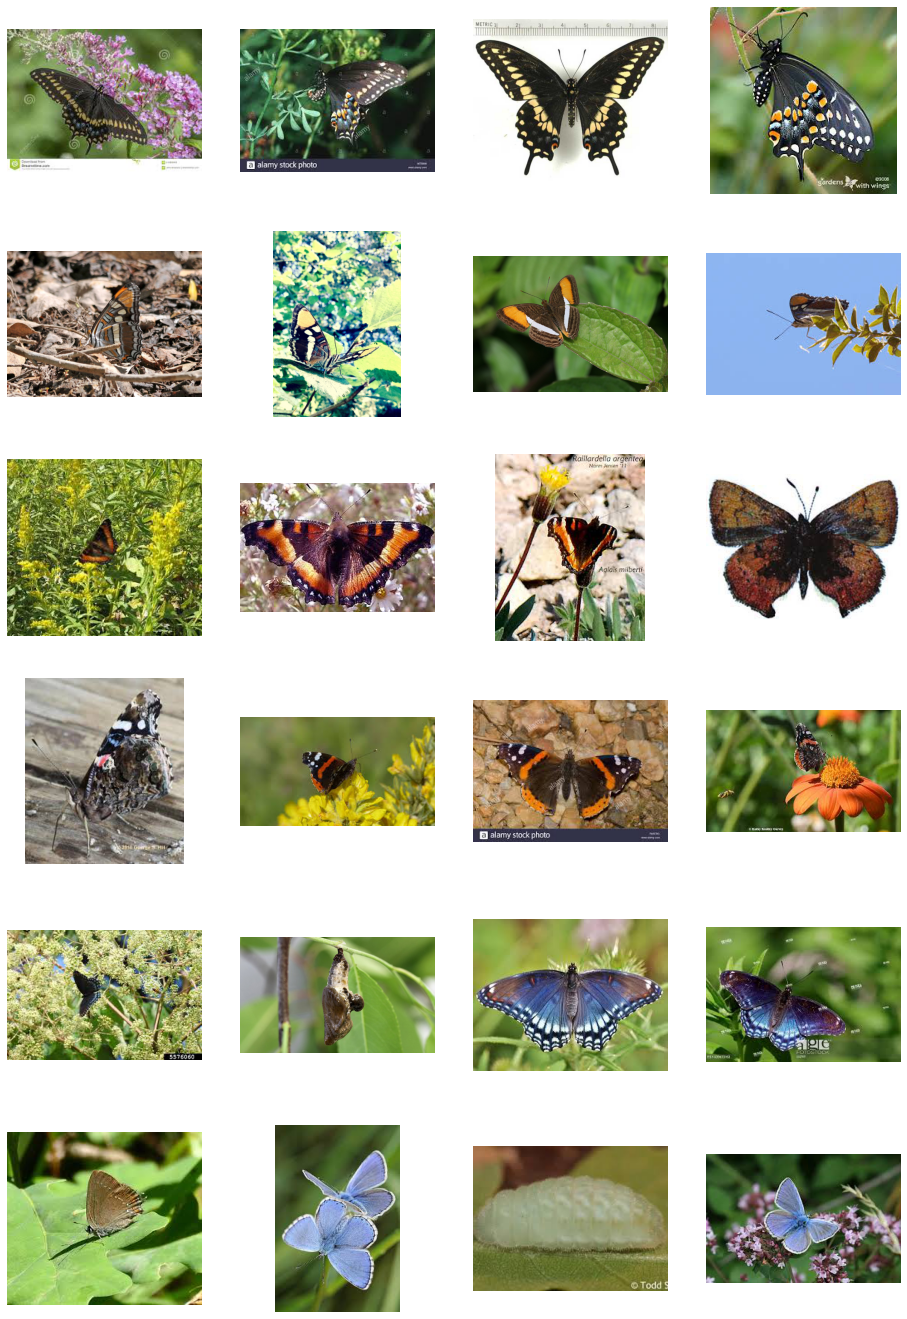

In [16]:
#Let's see the images present in the dataset.

import matplotlib.image as mpimg
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 7
next_b_pix = [os.path.join(train_b_dir, fname) 
                for fname in train_b_names[pic_index-4:pic_index]]
next_c_pix = [os.path.join(train_c_dir, fname) 
                for fname in train_c_names[pic_index-4:pic_index]]
next_m_pix = [os.path.join(train_m_dir, fname) 
                for fname in train_m_names[pic_index-4:pic_index]]
next_r_pix = [os.path.join(train_r_dir, fname) 
                for fname in train_r_names[pic_index-4:pic_index]]
next_s_pix = [os.path.join(train_s_dir, fname) 
                for fname in train_s_names[pic_index-4:pic_index]]
next_t_pix = [os.path.join(train_t_dir, fname) 
                for fname in train_t_names[pic_index-4:pic_index]]

for i, img_path in enumerate(next_b_pix+next_c_pix+next_m_pix+next_r_pix+next_s_pix+next_t_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## 4. Building Model from Scratch

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    #after 6 layers we use flatten to create single vector along with activation function

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),

  #since it's a multi-class hence we'll use softmax activation function.

    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        3

In [0]:
#compiling the model by setting the type of classifier, optimizer, acc we want in output

#using the RMSprop optimization algorithm is preferable to stochastic 
#gradient descent (SGD), because RMSprop automates learning-rate tuning for us. 
model.compile(optimizer = RMSprop(lr=1e-4),
              loss = 'categorical_crossentropy',metrics=['accuracy'])

## 5.1 Data Preprocessing

In [27]:
train_datagen = ImageDataGenerator(
      rescale=1./255.,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
        training_dir,  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=32,
        # Since we use sparse_categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

Found 1793 images belonging to 6 classes.
Found 774 images belonging to 6 classes.


## 6.1 Training on Scratch model

In [0]:
history = model.fit(
      train_generator,
      steps_per_epoch=57,  # 1800 images = batch_size * steps
      epochs=80,
      validation_data=validation_generator,
      validation_steps=25,
     verbose=1
      
)

## 6.2 Visualization of results



In [0]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()



plt.show()

____________________________________________________________________________

In [28]:

#here's a direct api to call the inception model without downloading it 

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None) # Your Code Here

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False #Your Code Here

#Print the model summary
pre_trained_model.summary()



--2020-05-01 13:43:03--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 2607:f8b0:400c:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   237MB/s    in 0.4s    

2020-05-01 13:43:04 (237 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                 

In [29]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output 

last layer output shape:  (None, 7, 7, 768)


In [0]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.9):
            print("\nReached 90.0% accuracy so cancelling training!")
            self.model.stop_training = True

      

In [32]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (6, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_100[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255.,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
        training_dir,  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=32,
        # Since we use sparse_categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

Found 1793 images belonging to 6 classes.
Found 774 images belonging to 6 classes.


## 6.1 Training on Transfered model

In [0]:
history = model.fit(
      train_generator,
      steps_per_epoch=57,  # 1800 images = batch_size * steps
      epochs=80,
      validation_data=validation_generator,
      validation_steps=25,
     verbose=1
      
)

## 6.2 Visualization of results



In [0]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()



plt.show()

## Testing the model

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

 
  plt.imshow(img)

  plt.show()

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

  for i in classes:
    if classes[0][0]==1:
      print('It is ')
    elif classes[0][1]==1:
      print('It is a ')
    elif classes[0][2]==1:
      print('It is a')
    elif classes[0][3]==1:
      print('It is a ')
    elif classes[0][3]==1:
      print('It is a ')
    elif classes[0][3]==1:
      print('It is a ')    

## Conclusion